# OOI Arrays: Overview and Context for CHLA Profiling
**Author:** Eli Holmes (NOAA)</br>
Last updated: Dec 5, 2025

The [Ocean Observatories Initiative (OOI)](https://oceanobservatories.org/) is a long-term, NSF-funded ocean observing program designed to provide continuous, high-resolution measurements across key regions of the global and coastal ocean.  
OOI systems collect physical, chemical, biological, and geological observations using a combination of:

- **Moorings: fixed location** (surface, mid-water, deep-water) — These are sensors at fixed discrete depths. CHLA is available only at those specific depths.

- **Depth Profiler systems: fixed location**  
  - **Wire-following profilers (WFPs)** — Provide high-resolution vertical depth profiles, sampling repeatedly up and down the water column.  
  - **Shallow profilers (SPs)** — Motorized profilers delivering dense CHLA depth profiles in the 0-200m range, often with higher sampling frequency than WFPs.  
  - **Deep profilers (DPs)** — Provide deep water (> 200m) vertical profiles.

- **Autonomous gliders: moving location** — Mobile platforms that execute repeated sawtooth depth profiles and produce full vertical CHLA measurements for each dive.

Across these platforms, OOI instruments collect high-frequency, vertically resolved biological measurements, including:
chlorophyll-a concentration, particulate organic matter & phytoplankton biomass, colored dissolved organic matter (CDOM), photosynthetically available radiation (PAR), sea water physical properties (temperature, salinity, and density), dissolved oxygen, nitrate, pH, pCO₂.  We are interested in modeling CHLA vertical depth profiles and will focus on the chlorophyll-a concentration measurement. OOI data is openly available through the OOI Data Portal and ERDDAP servers.


![](Supporting_files/ooi.jpg)



## OOI Regional Arrays

OOI consists of **two major coastal arrays**, a **regional cabled array**, and **four global open-ocean arrays**. Coastal arrays sample continental shelf, slope, and upwelling environments that exhibit strong seasonal biological and physical variability. These sites typically include vertically profiling platforms that provide **full or partial CHLA depth profiles** in the upper 0–200 m. Global Arrays observe key climate-relevant open-ocean regions and generally **do not include vertical profilers**, but they do provide **CHLA at fixed depths** within the 0–200 m zone, which can still be mapped into depth bins.

1. **Coastal Stations:**
    - **Endurance Array (Oregon & Washington)** — Samples an eastern boundary upwelling system across nearshore, shelf, and offshore environments. Platforms include surface and subsurface moorings (fixed-depth CHLA), **wire-following profilers** (0–200 m), **cabled shallow/deep profilers**, and autonomous gliders (0–200+ m profiles).
    - **Pioneer Array (Northwest Atlantic / Mid-Atlantic Bight)** — Observes cross-shelf and shelf-break frontal systems with strong biological gradients. Platforms include multi-tier moorings, surface buoys, gliders, and (in most years) **shallow profilers** that provided high-resolution 0–200 m CHLA profiles.
    - **Regional Cabled Array (Washington–Oregon offshore)** — Provides real-time power and data to offshore slope and deepwater nodes. Only the **cabled shallow profilers** contribute 0–200 m CHLA profiles; most deep or seafloor instruments do not sample CHLA.

2. **Global Stations:**
    - **Papa Array (Gulf of Alaska)** — Subarctic gyre; CHLA sensors at fixed depths (typically 7–50 m).
    - **Irminger Sea Array (Greenland–Iceland region)** — High-latitude convection region; CHLA at fixed depths in the upper 100 m.
    - **Argentine Basin Array (Southwest Atlantic)** — Deep-ocean circulation site; limited CHLA at one or two fixed depths (~30 m).
    - **Southern Ocean Array (South of Tasmania)** — High-mixing Southern Ocean environment; CHLA measurements at fixed depths in the upper 50 m.



## Workflow

This notebook processes CHLA data from OOI platforms showing:

- automated ERDDAP retrieval,  
- daily depth-binned CHLA profiles,  
- merged datasets across platforms and regions.

We work with a set of Endurance platforms listed in `endurance_dict`, including:

- **Offshore and shelf surface moorings** (near-surface instrument frames with fluorometers)
- **Cabled shallow and deep profilers**
- **Wire-following profilers** on offshore moorings
- **Inshore and shelf surface-piercing profilers**

For each platform, we:

1. Request CHLA data from the OOI ERDDAP server.
2. Process the data into **daily mean CHLA profiles** in fixed 10 m depth bins between 0 and 200 m.
3. Save per-platform parquet files and then merge them into a single, combined Endurance dataset.
4. Plot example CHLA–depth profiles for individual daily "profiles" (platform × day).


## Inspect ERDDAP variables for a single Endurance instrument

First, inspect the available variables for one representative dataset on the OOI ERDDAP server.  
This helps confirm the exact variable names for chlorophyll-a and related quality-control flags before building generalized code.


In [24]:
# See the variables
import pandas as pd
base = "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap"
dataset_id = "ooi-ce04osps-sf01b-3a-flortd104"
header_url = f"{base}/{dataset_id}.csv?"
# read only the header, skip the units row
df0 = pd.read_csv(header_url, skiprows=[1], nrows=0)
print(df0.columns)

Index(['time', 'latitude', 'longitude', 'z',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled_qc_agg',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled_qc_tests',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_tests',
       'depth_reading_profiler_depth_enabled',
       'depth_reading_profiler_depth_enabled_qc_agg',
       'depth_reading_profiler_depth_enabled_qc_tests',
       'flubsct_profiler_depth_

## Prototype daily CHLA binning and profile plotting for one mooring

Here we prototype the workflow for **one Endurance instrument**:

- Request time series from ERDDAP.
- Convert depth from `z` (altitude, negative down) to positive meters.
- Filter to the 0–200 m range.
- Bin CHLA into 10 m depth bins (0–10, 10–20, …, 190–200 m).
- Aggregate to daily means per depth bin.
- Pick one daily profile and plot **CHLA vs depth**.


In [4]:
# See a dataframe with the variables we want
import pandas as pd
import os
import numpy as np
dataset_id = "ooi-ce04osps-sf01b-3a-flortd104"
chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled"
url = (
    "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/"
    f"{dataset_id}.csv?"
    "time%2Clatitude%2Clongitude%2Cz%2C"
    f"{chl_var}%2C"
    f"{chl_var}_qc_agg"
    "&time%3E=2024-03-01"
    "&time%3C=2025-12-05T00%3A00%3A00Z"
    "&z%3E=-200"
)
df = pd.read_csv(url, skiprows=[1])
df["depth"] = -df["z"]    
qc_col = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg"
mask = (df["depth"] >= 0) & (df["depth"] < 200) & (df[qc_col] == 1.0)
df_good = df[mask].copy()
df_good

,time,latitude,longitude,z,mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled,mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg,depth
0,2024-03-01T00:00:00Z,44.369353,-124.954108,-161.0,0.033150,1,161.0
1,2024-03-01T00:01:00Z,44.369353,-124.954108,-161.0,0.030857,1,161.0
2,2024-03-01T00:02:00Z,44.369353,-124.954108,-161.0,0.037528,1,161.0
3,2024-03-01T00:03:00Z,44.369353,-124.954108,-161.0,0.038779,1,161.0
4,2024-03-01T00:04:00Z,44.369353,-124.954108,-161.0,0.022100,1,161.0
...,...,...,...,...,...,...,...
2350658,2025-12-04T23:56:00Z,44.369353,-124.954108,-192.0,0.047337,1,192.0
2350659,2025-12-04T23:57:00Z,44.369353,-124.954108,-192.0,0.046868,1,192.0
2350660,2025-12-04T23:58:00Z,44.369353,-124.954108,-192.0,0.049680,1,192.0
2350661,2025-12-04T23:59:00Z,44.369353,-124.954108,-192.0,0.049446,1,192.0


## Define a reusable function to fetch and bin CHLA from ERDDAP

Next we wrap the ERDDAP access and daily-binning logic into a reusable helper:

`ooi_mooring_save_file(url, description, id, save, out_dir)`

This function:

- Downloads CHLA (and QC flags, when available) from ERDDAP for a given dataset.
- Converts depths to positive meters and filters to 0–200 m.
- Computes **daily mean CHLA** in 10 m depth bins.
- Ensures all CHLA depth-bin columns (e.g., `CHLA_0_10`, …, `CHLA_190_200`) are present.
- Adds metadata such as latitude, longitude, description, and dataset ID.
- Optionally saves the daily profiles to a parquet file for that platform.


In [8]:
# Get and save a file
import numpy as np
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse
import os

def ooi_mooring_save_file(url, description=None, chl_var="mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled",
                          id=None, save=False, out_dir=Path("_temp_data/ooi")):

    df = pd.read_csv(url, skiprows=[1])

    qc_col = f"{chl_var}_qc_agg"
    
    # Rename CHLA columns
    df = df.rename(columns={
        chl_var: "CHLA",
    })
    
    chla_col = "CHLA"
    
    # Time + date
    df["time"] = pd.to_datetime(df["time"])
    df["date"] = df["time"].dt.floor("D")
    
    # Depth (positive down)
    df["depth"] = -df["z"]
    
    # Filter 0–200 m and QC
    mask = (df["depth"] >= 0) & (df["depth"] < 200) & (df[qc_col] == 1.0)
    df_good = df[mask].copy()
    
    # 10 m bins
    bins = np.arange(0, 210, 10)  # 0,10,...,200
    labels = [f"{b}-{b+10}" for b in bins[:-1]]
    
    df_good["depth_bin"] = pd.cut(
        df_good["depth"],
        bins=bins,
        labels=labels,
        right=False,
    )
    
    # ---- PER-DAY × DEPTH-BIN AGGREGATION (with lat/lon) ----
    grp = (
        df_good
        .groupby(["date", "depth_bin"], observed=True)
        .agg(
            lat=("latitude", "first"),
            lon=("longitude", "first"),
            chla=(chla_col, "mean"),
        )
        .reset_index()
    )
    
    # ---- PIVOT TO WIDE FORM ----
    wide = grp.pivot(
        index=["date", "lat", "lon"],
        columns="depth_bin",
        values="chla",
    ).reset_index()
    
    # Rename depth-bin columns "0-10" → "chla_0_10"
    wide.columns = [
        ("CHLA_" + str(c).replace("-", "_")) if c not in ("date", "lat", "lon") else c
        for c in wide.columns
    ]
    
    # rename date → time
    wide = wide.rename(columns={"date": "time"})

    if description is not None:
        wide["description"]=description

    if save:
        parsed = urlparse(url)
        path = parsed.path
        filename = os.path.basename(path)         # 'ooi-ce04osps-sf01b-3a-flortd104.csv'
        dataset_id = filename.split('.')[0]       # 'ooi-ce04osps-sf01b-3a-flortd104'
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = f"{out_dir}/{dataset_id}.parquet"
        wide.to_parquet(out_path)
        return wide, out_path
    
    return wide, None

## Define OOI platforms of interest

Here we list the OOI platforms we want to process.

Each key in `ooi_dict` is an ERDDAP `dataset_id` on `https://erddap.dataexplorer.oceanobservatories.org/erddap`, and each value is a human-readable description of the mooring or profiler (location and instrument type, e.g., 3-wavelength fluorometer).

In [9]:
# The files we want
# to do. add doi's from this: https://oceanobservatories.org/site-list/
ooi_dict = {
    "ooi-ce04ossm-rid27-02-flortd000": "Coastal Endurance: Oregon Offshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-ce04osps-sf01b-3a-flortd104": "Coastal Endurance: Oregon Offshore Cabled Shallow Profiler Mooring: Shallow Profiler (SF01B): 3-Wavelength Fluorometer",
    "ooi-ce09ospm-wfp01-04-flortk000": "Coastal Endurance: Washington Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-ce01issp-sp001-08-flortj000": "Coastal Endurance: Oregon Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce04ospd-dp01b-04-flntua103": "Coastal Endurance: Oregon Offshore Cabled Deep Profiler Mooring: Wire-Following Profiler (DP01B): 2-Wavelength Fluorometer",
    "ooi-ce02shsp-sp001-07-flortj000": "Coastal Endurance: Oregon Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce02shsp-sp002-07-flortj000": "Coastal Endurance: Oregon Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer B",
    "ooi-ce06issp-sp001-08-flortj000": "Coastal Endurance: Washington Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce07shsp-sp001-07-flortj000": "Coastal Endurance: Washington Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-cp10cnsm-rid27-02-flortd000": "Coastal Pioneer MAB: Central Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp13eapm-wfp01-04-flortk000": "Coastal Pioneer MAB: Eastern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp14nepm-wfp01-04-flortk000": "Coastal Pioneer MAB: Northeastern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp13nopm-wfp01-04-flortk000": "Coastal Pioneer MAB: Northern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp11nosm-rid27-02-flortd000": "Coastal Pioneer MAB: Northern Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp14sepm-wfp01-04-flortk000": "Coastal Pioneer MAB: Southeastern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp13sopm-wfp01-04-flortk000": "Coastal Pioneer MAB: Southern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp11sosm-rid27-02-flortd000": "Coastal Pioneer MAB: Southern Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp02pmci-wfp01-04-flortk000": "Coastal Pioneer NES: Central Inshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp02pmco-wfp01-04-flortk000": "Coastal Pioneer NES: Central Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp01cnpm-wfp01-04-flortk000": "Coastal Pioneer NES: Central Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp01cnsm-rid27-02-flortd000": "Coastal Pioneer NES: Central Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp01cnsp-sp001-09-flortj000": "Coastal Pioneer NES: Central Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-cp03ispm-wfp01-04-flortk000": "Coastal Pioneer NES: Inshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp03issm-rid27-02-flortd000": "Coastal Pioneer NES: Inshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp03issp-sp001-09-flortj000": "Coastal Pioneer NES: Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-cp04ospm-wfp01-04-flortk000": "Coastal Pioneer NES: Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp04ossm-rid27-02-flortd000": "Coastal Pioneer NES: Offshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp02pmui-wfp01-04-flortk000": "Coastal Pioneer NES: Upstream Inshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp02pmuo-wfp01-04-flortk000": "Coastal Pioneer NES: Upstream Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-rs03axps-pc03a-4c-flordd303": "Regional Cabled Array: Axial Base Shallow Profiler Mooring: 200m Platform (PC03A): 2-Wavelength Fluorometer",
    "ooi-rs03axps-sf03a-3a-flortd301": "Regional Cabled Array: Axial Base Shallow Profiler Mooring: Shallow Profiler (SF03A): 3-Wavelength Fluorometer",
    "ooi-rs01sbpd-dp01a-04-flntua102": "Regional Cabled Array: Oregon Slope Base Deep Profiler Mooring: Wire-Following Profiler (DP01A): 2-Wavelength Fluorometer",
    "ooi-rs01sbps-pc01a-4c-flordd103": "Regional Cabled Array: Oregon Slope Base Shallow Profiler Mooring: 200m Platform (PC01A): 2-Wavelength Fluorometer",
    "ooi-rs01sbps-sf01a-3a-flortd101": "Regional Cabled Array: Oregon Slope Base Shallow Profiler Mooring: Shallow Profiler (SF01A): 3-Wavelength Fluorometer",
    "ooi-gp02hypm-wfp03-01-flordl000": "Global Station Papa: Apex Profiler Mooring: Wire-Following Profiler Lower: 2-Wavelength Fluorometer",
    "ooi-gp02hypm-wfp02-01-flordl000": "Global Station Papa: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-gp03flma-ris01-05-flortd000": "Global Station Papa: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gp03flmb-ris01-05-flortd000": "Global Station Papa: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gi02hypm-wfp02-01-flordl000": "Global Irminger Sea: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-gi01sumo-rii11-02-flordg033": "Global Irminger Sea: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (130 meters)",
    "ooi-gi01sumo-rii11-02-flordg031": "Global Irminger Sea: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (40 meters)",
    "ooi-gi01sumo-rii11-02-flordg032": "Global Irminger Sea: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (80 meters)",
    "ooi-gi01sumo-rid16-02-flortd000": "Global Irminger Sea: Apex Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-gi01sumo-sbd12-02-flortd000": "Global Irminger Sea: Apex Surface Mooring: Surface Buoy: 3-Wavelength Fluorometer",
    "ooi-gi03flma-ris01-05-flortd000": "Global Irminger Sea: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gi03flmb-ris01-05-flortd000": "Global Irminger Sea: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-ga02hypm-wfp03-01-flordl000": "Global Argentine Basin: Apex Profiler Mooring: Wire-Following Profiler Lower: 2-Wavelength Fluorometer",
    "ooi-ga02hypm-wfp02-01-flordl000": "Global Argentine Basin: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-ga01sumo-rii11-02-flordg033": "Global Argentine Basin: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (130 meters)",
    "ooi-ga01sumo-rii11-02-flordg031": "Global Argentine Basin: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (40 meters)",
    "ooi-ga01sumo-rii11-02-flordg032": "Global Argentine Basin: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (80 meters)",
    "ooi-ga01sumo-rid16-02-flortd000": "Global Argentine Basin: Apex Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-ga01sumo-sbd12-02-flortd000": "Global Argentine Basin: Apex Surface Mooring: Surface Buoy: 3-Wavelength Fluorometer",
    "ooi-ga03flma-ris01-05-flortd000": "Global Argentine Basin: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-ga03flmb-ris01-05-flortd000": "Global Argentine Basin: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gs02hypm-wfp03-01-flordl000": "Global Southern Ocean: Apex Profiler Mooring: Wire-Following Profiler Lower: 2-Wavelength Fluorometer",
    "ooi-gs02hypm-wfp02-01-flordl000": "Global Southern Ocean: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-gs01sumo-rii11-02-flordg033": "Global Southern Ocean: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (130 meters)",
    "ooi-gs01sumo-rii11-02-flordg031": "Global Southern Ocean: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (40 meters)",
    "ooi-gs01sumo-rii11-02-flordg032": "Global Southern Ocean: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (80 meters)",
    "ooi-gs01sumo-rid16-02-flortd000": "Global Southern Ocean: Apex Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-gs01sumo-sbd12-02-flortd000": "Global Southern Ocean: Apex Surface Mooring: Surface Buoy: 3-Wavelength Fluorometer",
    "ooi-gs03flma-ris01-05-flortd000": "Global Southern Ocean: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gs03flmb-ris01-05-flortd000": "Global Southern Ocean: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
}

## Read data from ERDDAP and save per-platform daily CHLA files

This (optional) cell loops over all platforms in `endurance_dict` and:

- Builds an ERDDAP URL for each dataset.
- Calls `ooi_mooring_save_file(...)` to:
  - Download CHLA data.
  - Process it into daily 10 m-binned profiles.
  - Save the result as a parquet file in `_temp_data/ooi/`.

The cell is wrapped in `%%script false` so it will **not** run by default;  
uncomment it when you are ready to download data.


In [57]:
%%script false --no-raise-error
# comment to run
from pathlib import Path

out_dir = Path("_temp_data/ooi")
out_dir.mkdir(parents=True, exist_ok=True)

mooring_chl = ["ooi-ce04ossm-rid27-02-flortd000", 
               "ooi-cp10cnsm-rid27-02-flortd000",
               "ooi-cp11nosm-rid27-02-flortd000",
               "ooi-cp11sosm-rid27-02-flortd000",
               "ooi-cp01cnsm-rid27-02-flortd000",
               "ooi-cp03issm-rid27-02-flortd000",
               "ooi-cp04ossm-rid27-02-flortd000",
               "ooi-rs03axps-pc03a-4c-flordd303",
               "ooi-rs01sbps-pc01a-4c-flordd103",
               "ooi-gp03flma-ris01-05-flortd000",
               "ooi-gp03flmb-ris01-05-flortd000",
              "ooi-gi01sumo-rii11-02-flordg033",
              "ooi-gi01sumo-rii11-02-flordg031",
              "ooi-gi01sumo-rii11-02-flordg032",
              "ooi-gi01sumo-rid16-02-flortd000",
              "ooi-gi01sumo-sbd12-02-flortd000",
               "ooi-gi03flma-ris01-05-flortd000",
               "ooi-gi03flmb-ris01-05-flortd000",
               "ooi-ga01sumo-rii11-02-flordg033",
               "ooi-ga01sumo-rii11-02-flordg031",
               "ooi-ga01sumo-rii11-02-flordg032",
               "ooi-ga01sumo-rid16-02-flortd000",
               "ooi-ga01sumo-sbd12-02-flortd000",
               "ooi-ga03flma-ris01-05-flortd000",
               "ooi-ga03flmb-ris01-05-flortd000",
                "ooi-gs01sumo-rii11-02-flordg033",
               "ooi-gs01sumo-rii11-02-flordg031",
               "ooi-gs01sumo-rii11-02-flordg032",
               "ooi-gs01sumo-rid16-02-flortd000",
               "ooi-gs01sumo-sbd12-02-flortd000",
               "ooi-gs03flma-ris01-05-flortd000",
               "ooi-gs03flmb-ris01-05-flortd000",
              ]

for dataset_id, desc in ooi_dict.items():
    # choose chlorophyll variable name
    if dataset_id in mooring_chl:
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water"
    else:
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled"

    # expected parquet path for this dataset
    out_path = out_dir / f"{dataset_id}.parquet"

    # skip if file already exists
    if out_path.exists():
        print(f"Skipping {dataset_id}: {out_path} already exists")
        continue

    bad = [
            "ooi-cp02pmci-wfp01-04-flortk000", # no data in time range
            "ooi-cp02pmco-wfp01-04-flortk000", # no data in time range
            "ooi-cp01cnpm-wfp01-04-flortk000", # no data in time range
            "ooi-cp01cnsm-rid27-02-flortd000", # no data in time range
            "ooi-cp01cnsp-sp001-09-flortj000", # no data in time range
            "ooi-cp03ispm-wfp01-04-flortk000", # no data in time range
            "ooi-cp03issm-rid27-02-flortd000", # no data in time range
            "ooi-cp03issp-sp001-09-flortj000", # no data in time range
            "ooi-cp04ospm-wfp01-04-flortk000", # no data in time range
            "ooi-cp04ossm-rid27-02-flortd000", # no data in time range
            "ooi-cp02pmui-wfp01-04-flortk000", # no data in time range
            "ooi-cp02pmuo-wfp01-04-flortk000", # no data in time range
            "ooi-rs01sbpd-dp01a-04-flntua102", # no data in time range
            "ooi-ga02hypm-wfp03-01-flordl000", # no data in time range
            "ooi-ga02hypm-wfp02-01-flordl000", # no data in time range
            "ooi-ga01sumo-rii11-02-flordg033", # no data in time range
            "ooi-ga01sumo-rii11-02-flordg031", # no data in time range
            "ooi-ga01sumo-rii11-02-flordg032", # no data in time range
            "ooi-ga01sumo-rid16-02-flortd000", # no data in time range
            "ooi-ga01sumo-sbd12-02-flortd000", # no data in time range
            "ooi-ga03flma-ris01-05-flortd000", # no data in time range
            "ooi-ga03flmb-ris01-05-flortd000", # no data in time range
            "ooi-gs02hypm-wfp03-01-flordl000", # no data in time range
            "ooi-gs02hypm-wfp02-01-flordl000", # no data in time range
            "ooi-gs01sumo-rii11-02-flordg033", # no data in time range
            "ooi-gs01sumo-rii11-02-flordg031", # no data in time range
            "ooi-gs01sumo-rii11-02-flordg032", # no data in time range
            "ooi-gs01sumo-rid16-02-flortd000", # no data in time range
            "ooi-gs01sumo-sbd12-02-flortd000", # no data in time range
            "ooi-gs03flma-ris01-05-flortd000", # no data in time range
            "ooi-gs03flmb-ris01-05-flortd000", # no data in time range
            "ooi-ce02shsp-sp002-07-flortj000", # no qc
            "ooi-rs01sbps-pc01a-4c-flordd103", # no qc
            "ooi-gp02hypm-wfp03-01-flordl000", # 2000m and deeper
          ]
    # build URL (special case without qc_agg)
    if dataset_id in bad :
        continue
    else:
        url = (
            "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/"
            f"{dataset_id}.csv?"
            "time%2Clatitude%2Clongitude%2Cz%2C"
            f"{chl_var}%2C"
            f"{chl_var}_qc_agg"
            "&time%3E=2024-03-01"
            "&time%3C=2025-12-05T00%3A00%3A00Z"
            "&z%3E=-200"
        )

    print(f"Trying {dataset_id} with {url}")

    df, saved_path = ooi_mooring_save_file(
        url,
        description=desc,
        chl_var = chl_var,
        id=dataset_id,
        save=True,
        out_dir=out_dir,
    )
    print(f"Saved {dataset_id} ({desc}) to {saved_path}")



Skipping ooi-ce04ossm-rid27-02-flortd000: _temp_data/ooi/ooi-ce04ossm-rid27-02-flortd000.parquet already exists
Skipping ooi-ce04osps-sf01b-3a-flortd104: _temp_data/ooi/ooi-ce04osps-sf01b-3a-flortd104.parquet already exists
Skipping ooi-ce09ospm-wfp01-04-flortk000: _temp_data/ooi/ooi-ce09ospm-wfp01-04-flortk000.parquet already exists
Skipping ooi-ce01issp-sp001-08-flortj000: _temp_data/ooi/ooi-ce01issp-sp001-08-flortj000.parquet already exists
Skipping ooi-ce04ospd-dp01b-04-flntua103: _temp_data/ooi/ooi-ce04ospd-dp01b-04-flntua103.parquet already exists
Skipping ooi-ce02shsp-sp001-07-flortj000: _temp_data/ooi/ooi-ce02shsp-sp001-07-flortj000.parquet already exists
Skipping ooi-ce06issp-sp001-08-flortj000: _temp_data/ooi/ooi-ce06issp-sp001-08-flortj000.parquet already exists
Skipping ooi-ce07shsp-sp001-07-flortj000: _temp_data/ooi/ooi-ce07shsp-sp001-07-flortj000.parquet already exists
Skipping ooi-cp10cnsm-rid27-02-flortd000: _temp_data/ooi/ooi-cp10cnsm-rid27-02-flortd000.parquet already

## Inspect a single saved daily CHLA file

After running the ERDDAP download step, inspect one parquet file to verify:

- CHLA depth-bin columns are present and look reasonable.
- Time, latitude, and longitude are as expected for the platform.


In [69]:
# Examine the file
from pathlib import Path
import pandas as pd
out_dir = Path("_temp_data/ooi")
dataset_id = "ooi-ce01issp-sp001-08-flortj000"
out_path = f"{out_dir}/{dataset_id}.parquet"
df = pd.read_parquet(out_path)
df.head()

,time,lat,lon,CHLA_0_10,CHLA_10_20,CHLA_20_30,description
0,2024-04-11 00:00:00+00:00,44.65845,-124.0979,1.248099,1.369662,1.073702,Coastal Endurance: Oregon Inshore Surface Pier...
1,2024-04-12 00:00:00+00:00,44.65845,-124.0979,1.285849,1.286291,0.988821,Coastal Endurance: Oregon Inshore Surface Pier...
2,2024-04-17 00:00:00+00:00,44.65845,-124.0979,0.384099,0.510783,0.457698,Coastal Endurance: Oregon Inshore Surface Pier...
3,2024-04-18 00:00:00+00:00,44.65845,-124.0979,0.330928,0.311356,0.278780,Coastal Endurance: Oregon Inshore Surface Pier...
4,2024-04-19 00:00:00+00:00,44.65845,-124.0979,0.384770,0.366793,0.327334,Coastal Endurance: Oregon Inshore Surface Pier...


## Merge all platforms into a single OOI CHLA dataset

Here we:

- Read all per-platform parquet files from `_temp_data/ooi/`.
- Ensure that each file has **all** CHLA depth-bin columns (`CHLA_0_10`, …, `CHLA_190_200`), filling missing bins with `NaN`.
- Add a `profile_id` of the form `datasetID_YYYYMMDD` so each daily profile is uniquely identified by **platform × day**.
- Concatenate all platforms into a single dataframe and sort rows by time.
- Save the merged dataset to `_temp_data/ooi_chla_0_200m.parquet`.


In [73]:
#%%script false --no-raise-error
import numpy as np
import pandas as pd
from pathlib import Path

# directory where individual mooring parquet files live
out_dir = Path("_temp_data/ooi")

# all the CHLA columns you want to guarantee
chla_bins = [f"CHLA_{b}_{b+10}" for b in range(0, 200, 10)]

dfs = []

for p in out_dir.glob("*.parquet"):
    df = pd.read_parquet(p)

    # dataset_id from filename, e.g. "ooi-ce04osps-sf01b-3a-flortd104"
    dataset_id = p.stem

    # ensure time is datetime and make a date column
    df["time"] = pd.to_datetime(df["time"])
    date = df["time"].dt.floor("D")

    # profile_id = dataset_id_YYYYMMDD
    df["profile_id"] = dataset_id + "_" + date.dt.strftime("%Y%m%d")

    # ensure all CHLA_* columns exist
    for col in chla_bins:
        if col not in df.columns:
            df[col] = np.nan

    # consistent column order
    base_cols = ["profile_id", "time", "lat", "lon"]
    all_chla_cols = chla_bins
    other_cols = [c for c in df.columns if c not in base_cols + all_chla_cols]

    df = df[base_cols + all_chla_cols + other_cols]

    dfs.append(df)

# combine all rows
combined = pd.concat(dfs, ignore_index=True)

# sort by time (date) across all platforms
combined["time"] = pd.to_datetime(combined["time"])
combined = combined.sort_values("time").reset_index(drop=True)

# optional: save
combined_out = Path("_temp_data/ooi_chla_0_200m.parquet")
combined.to_parquet(combined_out)

combined.head()



,profile_id,time,lat,lon,CHLA_0_10,CHLA_10_20,CHLA_20_30,CHLA_30_40,CHLA_40_50,CHLA_50_60,...,CHLA_110_120,CHLA_120_130,CHLA_130_140,CHLA_140_150,CHLA_150_160,CHLA_160_170,CHLA_170_180,CHLA_180_190,CHLA_190_200,description
0,ooi-ce04ossm-rid27-02-flortd000_20240301,2024-03-01 00:00:00+00:00,44.365280,-124.939470,0.675962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coastal Endurance: Oregon Offshore Surface Moo...
1,ooi-gi03flmb-ris01-05-flortd000_20240301,2024-03-01 00:00:00+00:00,59.715220,-39.315150,0.348521,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Global Irminger Sea: Flanking Subsurface Moori...
2,ooi-rs03axps-sf03a-3a-flortd301_20240301,2024-03-01 00:00:00+00:00,45.830466,-129.753082,NaN,1.032399,1.128244,1.216156,1.239003,1.200323,...,0.031526,0.025329,0.020974,0.020147,0.020719,0.018667,0.023159,0.026216,NaN,Regional Cabled Array: Axial Base Shallow Prof...
3,ooi-ce09ospm-wfp01-04-flortk000_20240301,2024-03-01 00:00:00+00:00,46.852180,-124.974610,NaN,NaN,NaN,0.712121,0.697653,0.647610,...,0.029593,0.025464,0.023151,0.022770,0.021980,0.023111,0.022429,0.022202,0.024052,Coastal Endurance: Washington Offshore Profile...
4,ooi-gp02hypm-wfp02-01-flordl000_20240301,2024-03-01 00:00:00+00:00,50.070370,-144.800750,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.030767,0.037275,0.038340,0.031950,Global Station Papa: Apex Profiler Mooring: Wi...


## Select a random daily profile and plot CHLA vs depth

Finally, we:

- Load the merged Endurance CHLA dataset.
- Identify `profile_id` values with at least a minimum number of non-NaN CHLA depth bins.
- Randomly select one valid daily profile.
- Retrieve the platform description for context.
- Convert CHLA depth-bin columns into depth midpoints and plot **CHLA vs depth** for the selected daily profile.


Using profile_id: ooi-cp14nepm-wfp01-04-flortk000_20240629 with 18 valid CHLA bins


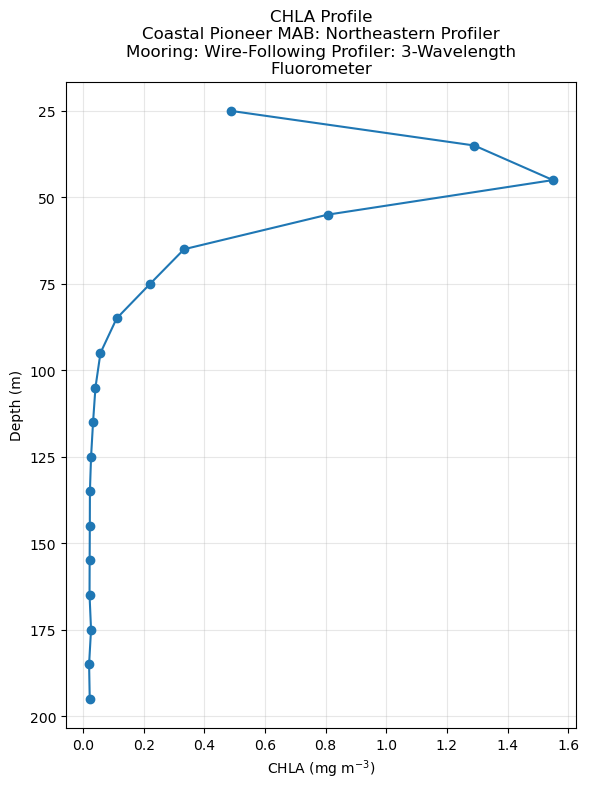

In [75]:
# Create a plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap

# ---- 1. Load combined dataset ----
combined_path = Path("_temp_data/ooi_chla_0_200m.parquet")
df = pd.read_parquet(combined_path)

# Ensure time is datetime (not strictly needed for the plot, but nice to have)
df["time"] = pd.to_datetime(df["time"])

# ---- 2. Identify CHLA columns and pick a good profile ----
chla_cols = [c for c in df.columns if c.startswith("CHLA_")]

if not chla_cols:
    raise ValueError("No CHLA_ columns found in the dataframe.")

# Count how many non-NaN CHLA values each profile_id has (per row)
# (Assumes one row per profile_id; if multiple, takes the max across rows.)
counts = (
    df.groupby("profile_id")[chla_cols]
      .apply(lambda x: x.notna().sum(axis=1).max())
)

# Get a profile_id with at least 10 valid CHLA bins
valid_profiles = counts[counts >= 10]
if valid_profiles.empty:
    raise ValueError("No profile_id found with at least 10 non-NaN CHLA bins.")

rand_row = valid_profiles.sample(1, random_state=None)  # set an int seed if you want reproducible

profile_id = rand_row.index[0]
n_bins = rand_row.iloc[0]

print(f"Using profile_id: {profile_id} with {n_bins} valid CHLA bins")

# Get Description
desc = df.loc[df["profile_id"] == profile_id, "description"].iloc[0]

# ---- 3. Extract that profile ----
sub = df[df["profile_id"] == profile_id].copy()

# If there somehow are multiple rows for this profile, average them
if len(sub) > 1:
    sub = sub.groupby("profile_id")[chla_cols].mean().reset_index()
else:
    sub = sub.reset_index(drop=True)

# Take the first (or only) row of CHLA values
chla_vals = sub[chla_cols].iloc[0].values

# ---- 4. Build depth midpoints from CHLA_0_10 style column names ----
# CHLA_0_10 -> lower edge = 0 -> midpoint = 5
depths = []
for col in chla_cols:
    # col format assumed: "CHLA_<z1>_<z2>"
    parts = col.split("_")
    if len(parts) < 3:
        raise ValueError(f"Unexpected CHLA column format: {col}")
    z1 = int(parts[1])
    z_mid = z1 + 5  # 10 m bin midpoint
    depths.append(z_mid)

depths = np.array(depths)
chla_vals = np.array(chla_vals, dtype=float)

# Sort by depth (just in case columns are out of order)
order = np.argsort(depths)
depths = depths[order]
chla_vals = chla_vals[order]

# Mask out NaNs so the plot doesn't connect them
valid = ~np.isnan(chla_vals)
depths_valid = depths[valid]
chla_valid = chla_vals[valid]

# ---- 5. Plot CHLA vs depth ----
plt.figure(figsize=(6, 8))
plt.plot(chla_valid, depths_valid, marker="o")

plt.gca().invert_yaxis()  # surface at top
plt.xlabel("CHLA (mg m$^{-3}$)")
plt.ylabel("Depth (m)")
wrapped_desc = textwrap.fill(desc, width=50)  # adjust width to taste
plt.title(f"CHLA Profile\n{wrapped_desc}")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Match ups to PACE

In [76]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/fish-pace-datasets/ml_utils.py'>

In [80]:
# Load data from GitHub
df_y_name="CHLA"; df_lat_name="lat"; df_lon_name="lon"; df_time_name="time"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/fish-pace-datasets/main/data"
url = f"{base_url}/CHLA_ooi_profiles.parquet"
ooi_chl_df = pd.read_parquet(url)
len(ooi_chl_df)

9782

In [81]:
%%time
from datetime import datetime

def run_batch(
    results, df, 
    ds_vec_name="wavelength", ds_var_name="Rrs", ds_vec_sel=None,
    df_time_name="time", df_lat_name="lat", df_lon_name="lon"
):
    """
    Run a batch of PACE files (results) and return PACE variables for lat/lon/time rows in a
    dataframe.

    Parameters
    ----------
    results : earthaccess results object as returned by `earthaccess.search`). 
    
    df : A pandas DataFrame containing Argo observations. Must include columns for
        time, latitude, longitude.

    ds_vec_name : str or None, optional
        Name of the spectral dimension in the PACE dataset (e.g. "wavelength").
        If not None, matched satellite spectra are returned with one column per
        wavelength. If None, only a single variable is extracted.

    ds_vec_sel : value or None, optional
        Value of the spectral dimension in the PACE dataset (e.g. "wavelength")
        to select. If None, matched satellite spectra are returned with one column per
        wavelength. If given, only a single variable is extracted for that value.

    ds_var_name : str, optional
        Name of the variable to extract from the PACE dataset
        (e.g. "Rrs" or "chlor_a").

    df_lat_name, df_lon_name, df_time_name : str, optional
        Column names in `df` for latitude, longitude, and time.
    """

    # Make sure to refresh fileset to minimize the chance that the token expires before we are done
    # this for loop consumes about 6Gb of RAM
    fileset = earthaccess.open(results, pqdm_kwargs={"disable": True} );
    
    df_plus = []
    for i, f in enumerate(fileset):
        df_record, pts = mu.one_file_matches(
            f, df, 
            ds_vec_name=ds_vec_name, ds_var_name=ds_var_name, ds_vec_sel=ds_vec_sel,
            df_time_name=df_time_name, df_lat_name=df_lat_name, df_lon_name=df_lon_name)
        if df_record is None or len(df_record) == 0: 
            print(f"Skipped day {i} no data in df")
            continue
        # error check
        if len(df_record) != len(pts):
            raise ValueError(f"Row mismatch: df_record={len(df_record)}, pts={len(pts)}")
    
        # left "concat": keep df_record rows, add pts columns by position
        df_record_plus = pd.concat(
            [ 
                df_record.reset_index(drop=True), 
                pts.reset_index(drop=True),
            ], axis=1,)
        df_plus.append(df_record_plus)
    if not len(df_plus) == 0:
        df_plus = pd.concat(df_plus, ignore_index=True)
    return df_plus

CPU times: user 13 μs, sys: 1 μs, total: 14 μs
Wall time: 17.6 μs


In [ ]:
# Load data from GitHub
df_y_name="CHLA"; df_lat_name="LATITUDE"; df_lon_name="LONGITUDE"; df_time_name="TIME"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/data/argo_monthly_nc/"
url = f"{base_url}argo_profiles_index.parquet"
argo_chl_df = pd.read_parquet(url)
len(argo_chl_df)

## Get Rrs

In [84]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
df = ooi_chl_df
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (df.time.min(), df.time.max()),
    granule_name="*.DAY.*.4km.*"
)
rrs_results_nrt = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS_NRT",
    temporal = (df.time.min(), df.time.max()),
    granule_name="*.DAY.*.4km.*"
)
results = rrs_results + rrs_results_nrt
print(f"{len(results)} days of PACE data")

718 days of PACE data


In [86]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("_temp_data/matchups/ooi")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "CHLA"
results = results
df = ooi_chl_df
ds_var = "Rrs"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_{ds_var}_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, df)  # returns a DataFrame

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")

Batch 1: 10 files: 18:57:44
  -> Saved 118 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_001.parquet
Batch 2: 10 files: 18:58:08
  -> Saved 109 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_002.parquet
Batch 3: 10 files: 18:58:24
  -> Saved 109 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_003.parquet
Batch 4: 10 files: 18:58:44
  -> Saved 168 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_004.parquet
Batch 5: 10 files: 18:59:13
  -> Saved 190 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_005.parquet
Batch 6: 10 files: 18:59:45
  -> Saved 180 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_006.parquet
Batch 7: 10 files: 19:00:15
  -> Saved 183 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_007.parquet
Batch 8: 10 files: 19:00:47
  -> Saved 189 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_008.parquet
Batch 9: 10 files: 19:01:19
  -> Saved 185 rows to _temp_data/matchups/ooi/CHLA_matchups_Rrs_batch_009.parquet
B

In [87]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd

results_dir = Path("_temp_data/matchups/ooi")
var = "CHLA"
ds_var = "Rrs"

batch_files = sorted(results_dir.glob(f"{var}_matchups_{ds_var}_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"{results_dir}/{var}_ooi_{ds_var}_all.parquet", index=False)


In [88]:
print(f"Total rows: {len(df_all)}")

Total rows: 10989


## Get chlor_a

In [89]:
# Add on chla to the clean parquet
import pandas as pd
import earthaccess
import xarray as xr
time_range = (ooi_chl_df.time.min(), ooi_chl_df.time.max())

# Get PACE CHL data
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
chl_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = time_range,
    granule_name="*.DAY.*.4km.*"
)
chl_results_nrt = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL_NRT",
    temporal = time_range,
    granule_name="*.DAY.*.4km.*"
)
results = chl_results + chl_results_nrt
print(f"{len(results)} days of PACE data")

718 days of PACE data


In [91]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("_temp_data/matchups/ooi")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "CHLA"
results = results
df = ooi_chl_df
ds_var = "chlor_a"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_{ds_var}_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, df, ds_vec_name=None, ds_var_name="chlor_a")

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")

Batch 1: 10 files: 20:04:20
  -> Saved 118 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_001.parquet
Batch 2: 10 files: 20:04:30
  -> Saved 109 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_002.parquet
Batch 3: 10 files: 20:04:35
  -> Saved 109 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_003.parquet
Batch 4: 10 files: 20:04:39
  -> Saved 168 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_004.parquet
Batch 5: 10 files: 20:04:44
  -> Saved 190 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_005.parquet
Batch 6: 10 files: 20:04:49
  -> Saved 180 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_006.parquet
Batch 7: 10 files: 20:04:54
  -> Saved 183 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_007.parquet
Batch 8: 10 files: 20:05:00
  -> Saved 189 rows to _temp_data/matchups/ooi/CHLA_matchups_chlor_a_batch_008.parquet
Batch 9: 10 files: 20:05:05
  -> Saved 185 rows to _temp_data/matchups/ooi/CHLA_

In [92]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd

results_dir = Path("_temp_data/matchups/ooi")
platform = "ooi"
var = "CHLA"
ds_var = "chlor_a"

batch_files = sorted(results_dir.glob(f"{var}_matchups_{ds_var}_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"{results_dir}/{var}_{platform}_{ds_var}_all.parquet", index=False)


## Kd_490

In [93]:
# Add on chla to the clean parquet
import pandas as pd
import earthaccess
import xarray as xr
time_range = (ooi_chl_df.time.min(), ooi_chl_df.time.max())

# Get PACE CHL data
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
kd_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    temporal = time_range,
    granule_name="*.DAY.*.4km.*"
)
kd_results_nrt = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD_NRT",
    temporal = time_range,
    granule_name="*.DAY.*.4km.*"
)
results = kd_results + kd_results_nrt
print(f"{len(results)} days of PACE data")

718 days of PACE data


In [95]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("_temp_data/matchups/ooi")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "CHLA"
results = results
df = ooi_chl_df
ds_var = "Kd"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_{ds_var}_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, ooi_chl_df, ds_var_name="Kd", ds_vec_sel=490.0)

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")

Batch 1: 10 files: 20:24:00
  -> Saved 118 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_001.parquet
Batch 2: 10 files: 20:24:24
  -> Saved 109 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_002.parquet
Batch 3: 10 files: 20:24:30
  -> Saved 109 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_003.parquet
Batch 4: 10 files: 20:24:35
  -> Saved 168 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_004.parquet
Batch 5: 10 files: 20:24:42
  -> Saved 190 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_005.parquet
Batch 6: 10 files: 20:24:49
  -> Saved 180 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_006.parquet
Batch 7: 10 files: 20:24:56
  -> Saved 183 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_007.parquet
Batch 8: 10 files: 20:25:03
  -> Saved 189 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_008.parquet
Batch 9: 10 files: 20:25:10
  -> Saved 185 rows to _temp_data/matchups/ooi/CHLA_matchups_Kd_batch_009.parquet
Batch 10: 

In [96]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd

results_dir = Path("_temp_data/matchups/ooi")
platform = "ooi"
var = "CHLA"
ds_var = "Kd"

batch_files = sorted(results_dir.glob(f"{var}_matchups_{ds_var}_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"{results_dir}/{var}_{platform}_{ds_var}_all.parquet", index=False)


In [98]:
from pathlib import Path
import pandas as pd
import numpy as np

results_dir = Path("_temp_data/matchups/ooi")
platform = "ooi"
var = "CHLA"

df_all_kd = pd.read_parquet(f"{results_dir}/{var}_{platform}_Kd_all.parquet")
df_all_chl = pd.read_parquet(f"{results_dir}/{var}_{platform}_chlor_a_all.parquet")
df_all_rrs = pd.read_parquet(f"{results_dir}/{var}_{platform}_Rrs_all.parquet")


In [105]:
print(df_all_kd.shape)
print(df_all_rrs.shape)

(10989, 31)
(10989, 202)


In [154]:
df_all_chl.columns

Index(['profile_id', 'time', 'lat', 'lon', 'CHLA_0_10', 'CHLA_10_20',
       'CHLA_20_30', 'CHLA_30_40', 'CHLA_40_50', 'CHLA_50_60', 'CHLA_60_70',
       'CHLA_70_80', 'CHLA_80_90', 'CHLA_90_100', 'CHLA_100_110',
       'CHLA_110_120', 'CHLA_120_130', 'CHLA_130_140', 'CHLA_140_150',
       'CHLA_150_160', 'CHLA_160_170', 'CHLA_170_180', 'CHLA_180_190',
       'CHLA_190_200', 'description', 'pace_chlor_a_file',
       'pace_chlor_a_t_start', 'pace_chlor_a_t_end', 'pace_chlor_a_lat',
       'pace_chlor_a_lon', 'pace_chlor_a'],
      dtype='object')

In [133]:
n = 5
assert np.array_equal(
    df_all_chl.iloc[:, n].values,
    df_all_chl.iloc[:, n].values,
    equal_nan=True,
), "First n column values differ"


## Merge PACE matchups all together

In [178]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd
import numpy as np

results_dir = Path("_temp_data/matchups/ooi")
platform = "ooi"
var = "CHLA"

df_all_kd = pd.read_parquet(f"{results_dir}/{var}_{platform}_Kd_all.parquet")
df_all_chl = pd.read_parquet(f"{results_dir}/{var}_{platform}_chlor_a_all.parquet")
df_all_rrs = pd.read_parquet(f"{results_dir}/{var}_{platform}_Rrs_all.parquet")

# check 
n = 4
assert np.array_equal(
    df_all_chl.iloc[:, :n].values,
    df_all_rrs.iloc[:, :n].values,
), "First n column values differ"
assert np.array_equal(
    df_all_kd.iloc[:, :n].values,
    df_all_rrs.iloc[:, :n].values,
), "First n column values differ"
n1 = 5
n2 = 23
assert np.array_equal(
    df_all_chl.iloc[:, n1:n2].values,
    df_all_rrs.iloc[:, n1:n2].values,
    equal_nan=True,
), "First n column values differ"
assert np.array_equal(
    df_all_kd.iloc[:, n1:n2].values,
    df_all_rrs.iloc[:, n1:n2].values,
    equal_nan=True,
), "First n column values differ"

# columns to add
df_chl_extra = df_all_chl["pace_chlor_a"]
df_kd_extra = df_all_kd["pace_Kd_490"]
# Horizontal concat: rrs on the left, extras on the right
df_merged = pd.concat([df_all_rrs, df_chl_extra, df_kd_extra], axis=1)
df_merged.to_parquet(f"{results_dir}/{var}_{platform}_Rrs_chlor_a_Kd_all.parquet", index=False)

## Remove duplicates

In [179]:
# Cleaned; 
# Duplicates replaced with the PACE data that is closest to TIME

import pandas as pd
from pathlib import Path
results_dir = Path("_temp_data/matchups/ooi")
platform = "ooi"
var = "CHLA"

df_merged = pd.read_parquet(f"{results_dir}/{var}_{platform}_Rrs_chlor_a_Kd_all.parquet")

df = df_merged

# Parse all times as UTC-aware datetimes
for col in ["time", "pace_Rrs_t_start", "pace_Rrs_t_end"]:
    df[col] = pd.to_datetime(df[col], utc=True)

# is file NRT
df["nrt"] = [("NRT" in f) for f in df["pace_Rrs_file"]]
idx = df.groupby("profile_id")["nrt"].idxmin()
df = df.loc[idx].drop(columns=["nrt"]).reset_index(drop=True)

# Just in case there are 2 files due to slightly overlapping time windows
# though turns out there were not any
# center of the PACE time window
df["pace_center"] = df["pace_Rrs_t_start"] + (
    df["pace_Rrs_t_end"] - df["pace_Rrs_t_start"]
) / 2

# 2. absolute time difference between profile TIME and window center
df["time_diff"] = (df["time"] - df["pace_center"]).abs()

# 3. for each profile_id, keep the row with smallest time_diff
idx = df.groupby("profile_id")["time_diff"].idxmin()

df_dedup = df.loc[idx].drop(columns=["pace_center", "time_diff"]).reset_index(drop=True)
df_dedup = df_dedup.sort_values(by="time").reset_index(drop=True)
print(df_dedup.shape)
# double-check
df_dedup['profile_id'].duplicated().any()

(6415, 204)


np.False_

In [180]:
out_path = "data/CHLA_ooi_profiles_plus_PACE.parquet"
df_merged.to_parquet(out_path)

## Create metadata

In [182]:
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
import pandas as pd

out_path = "data/CHLA_ooi_profiles_plus_PACE.parquet"
df = pd.read_parquet(out_path)

table = pa.Table.from_pandas(df)

file_meta = {
    "title": "Global OOI CHLA profile metrics (0 to 200 m, 10 m bins) with PACE Rrs, chlor_a and Kd_490 matchups",
    "creator": "Eli Holmes / NOAA https://orcid.org/0000-0001-9128-8393",
    "created": datetime.utcnow().isoformat() + "Z",
    "source": (
        "OOI data (via ERDDAP) and Daily 4km PACE data v 3.1 collections "
        "PACE_OCI_L3M_RRS, PACE_OCI_L3M_CHL and PACE_OCI_L3M_KD via NASA Earthdata. "
        "NSF Ocean Observatories Initiative. (2014). Data from 2024-03-01 to 2025-12-05. Data Explorer ERDDAP. https://erddap.dataexplorer.oceanobservatories.org] doi:10.58046/OOI-CP03ISSM. Accessed on 2025-12-05."
        "See profile_id column for exact platform used."
    ),
    "description": (
        "All OOI Profiler and Mooring Florometer data Mar 2024 to Nov 2025 with CHLA variable was downloaded. "
        "Data accessed on https://erddap.dataexplorer.oceanobservatories.org/erddap. data_id is the profile_id in file."
        "Per-profile depth-binned CHLA means (0–200 m by 10 m bins) were computed for each depth bin. "
        "QC filtering was done on the values using the _qc_agg variable. Values filtered to qc=1."
        "All profiles were kept even if some binned averages were missing. "
        "PACE Rrs for all wavelengths, chlor_a, and Kd_490 were extracted from Level 3 4km v 3.1 Daily files. "
        "Matching was done by first selecting all profiles with TIME within 24 hours of t_start in the "
        "PACE Level 3 file. Note: t_start in the netcdf attributes was used, not the day in the netcdf filename or "
        "in the NASA Earthdata CMS. Once all profiles within that timerange were found, the LATITUDE/LONGITUDE point "
        "for the Argo profile was matched to the PACE Level 3 4km grid via ds.sel(lon=LONGITUDE, lat=LATITUDE, method='nearest') "
        "where ds is an xarray Dataset formed by reading in the PACE file. "
        "The actual PACE files used are listed in the dataset under pace_var_file. "
        "Note: the PACE data is heavily cloud-affected and the majority (≈80%) of PACE pixels are NaN."
        "Data were accessed using earthaccess Python package, example "
        "results = earthaccess.search_data(short_name = 'PACE_OCI_L3M_KD', temporal = ('2024-03-01', '2025-11-30'), granule_name='*.DAY.*.4km.*')"
    ),

    "profile_id_definition": "ERDDAP data id",
    "time_definition": "time in UTC reduced to day. All samples within the same day are given the same time stamp.",
    "lat_definition": "lat in the ERDDAP dataset. The OOI platforms are fixed (non-moving in lat/lon)",
    "lon_definition": "lon in the ERDDAP dataset.",

    "CHLA_A_B_definition": (
        "Depth-binned averages of CHLA. Computed as the average of all individual CHLA measurements within the depth interval and within a day."
        "(z>=A and z<B), where z is depth below surface. "
        "Data were filtered to qc_agg = 1 values."
    ),

    "pace_Rrs_lat_definition": "The matched latitude from the PACE Level 3 grid.",
    "pace_Rrs_lon_definition": "The matched longitude from the PACE Level 3 grid.",
    "pace_Rrs_t_start_definition": "Start time of the swath data used to create the Level 3 4km file. In UTC, from netcdf attributes.",
    "pace_Rrs_t_end_definition": "End time of the swath data used to create the Level 3 4km file. In UTC, from netcdf attributes.",
    "pace_Rrs_file_definition": "Filename for the Level 3 4km file. Only Rrs is shown but chlor_a and Kd_490 are analogous.",
    "pace_Rrs_A_definition": (
        "PACE_OCI_L3M_RRS Level 3 4km remote-sensing reflectance for wavelength A, "
        "where A is the center wavelength in nanometers (e.g., pace_Rrs_443 for 443 nm), "
        "extracted from PACE v 3.1 Daily files."
    ),

    "pace_chlor_a_definition": "PACE_OCI_L3M_CHL Level 3 4km chlor_a extracted from PACE v 3.1 Daily files.",
    "pace_Kd_490_definition": "PACE_OCI_L3M_KD Level 3 4km Kd_490 extracted from PACE v 3.1 Daily files.",

    "variable_lat_standard_name": "latitude",
    "variable_lat_units": "degrees_north",
    "variable_lon_standard_name": "longitude",
    "variable_lon_units": "degrees_east",

    "variable_pace_Rrs_lat_standard_name": "latitude",
    "variable_pace_Rrs_lat_units": "degrees_north",
    "variable_pace_Rrs_lon_standard_name": "longitude",
    "variable_pace_Rrs_lon_units": "degrees_east",
    "variable_pace_Rrs_t_start_standard_name": "time",
    "variable_pace_Rrs_t_start_units": "UTC",
    "variable_pace_Rrs_t_end_standard_name": "time",
    "variable_pace_Rrs_t_end_units": "UTC",

    "variable_pace_CHLA_prefix_definition": (
        "All columns whose names start with 'CHLA_' followed by two numbers "
        "are the averaged CHLA within a depth bin defined by the numbers. "
        "For example, 'CHLA_10_20' is the average CHLA between z>=10 and z<20 m."
    ),

    "CHLA_processing_description": (
        "CHLA values were taken directly from the OOI chl variable which was 'mass_concentration_of_chlorophyll_a_in_sea_water'"
        "for moorings and 'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled' for profilers."
        "(mg m-3). No additional sensor corrections or non-photochemical "
        "quenching adjustments were applied. QC was given in qc_agg column."
        "Values were filtered to qc_agg = 1. CHLA measurements were aggregated into 10 m "
        "depth bins between 0 and 200 m using arithmetic means for all values in a day."
    ),

    "CHLA_measurement_description": (
        "OOI chlorophyll-a (CHLA) is measured with WET Labs ECO fluorometers "
        "(e.g., FLORT/FLORD family) deployed on Ocean Observatories Initiative "
        "platforms. These sensors emit blue light (~470 nm) to excite "
        "chlorophyll pigments in the water and detect the resulting "
        "fluorescence in the red band near ~695 nm. Raw fluorescence counts are "
        "converted to chlorophyll-a concentration using factory calibration "
        "coefficients and OOI processing, which applies standard scale factors, "
        "dark corrections, and automated quality-control tests to produce the "
        "'fluorometric_chlor_a' data product (reported in approximately "
        "mg m⁻³). In this work, we use the OOI fluorometric chlorophyll-a "
        "values as provided by the OOI data system, without additional "
        "post-processing (e.g., non-photochemical quenching corrections or "
        "region-specific bias adjustments), so they should be interpreted as "
        "instrument-based estimates of relative chlorophyll-a concentration "
        "rather than fully validated absolute values."
    ),

    "variable_CHLA_standard_name": "mass_concentration_of_chlorophyll_a_in_sea_water",
    "variable_CHLA_units": "mg m-3",

    "variable_pace_Rrs_prefix_definition": (
        "All columns whose names start with 'pace_Rrs_' contain PACE OCI "
        "remote-sensing reflectance (Rrs) at the wavelength given by the suffix "
        "in nanometers. For example, 'pace_Rrs_443' is Rrs at 443 nm. "
        "Rrs is the ratio of water-leaving radiance to downwelling irradiance "
        "just above the sea surface."
    ),
    "variable_pace_Rrs_long_name": "Remote sensing reflectance",
    "variable_pace_Rrs_standard_name": (
        "surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_"
        "downwelling_radiative_flux_in_air"
    ),
    "variable_pace_Rrs_units": "sr-1",

    "Rrs_measurement_definition": (
        "Remote-sensing reflectance (Rrs) is the ratio of water-leaving radiance "
        "to downwelling irradiance just above the sea surface (sr-1). "
        "Rrs(λ) from PACE OCI is derived from top-of-atmosphere radiances "
        "after atmospheric correction that removes molecular scattering, "
        "aerosol scattering, and surface glint contributions. "
        "Rrs represents the spectral signature of the ocean water column "
        "and is the primary input for bio-optical algorithms. "
        "PACE OCI provides hyperspectral Rrs from 350–890 nm at 5 nm resolution. "
        "pace_Rrs_λ variables in this dataset correspond to center wavelengths "
        "equal to the value in the variable name (e.g., pace_Rrs_443 for 443 nm)."
    ),

    "pace_chlor_a_long_name": "Chlorophyll Concentration, OCI Algorithm",
    "pace_chlor_a_standard_name": "mass_concentration_of_chlorophyll_a_in_sea_water",
    "pace_chlor_a_units": "mg m-3",
    "pace_chlor_a_valid_min": "0.001",
    "pace_chlor_a_valid_max": "100.0",

    "pace_chlor_a_measurement_definition": (
        "From PACE v 3.1 Level 3 files: PACE OCI chlorophyll-a concentration (chlor_a) "
        "is computed using the OCI Chlorophyll Algorithm (CI algorithm) described by "
        "Hu, Lee, and Franz (2012). The CI algorithm estimates chlorophyll-a "
        "concentration from hyperspectral remote-sensing reflectance (Rrs) using a "
        "three-band baseline difference approach optimized for clear to moderately "
        "productive waters. Values represent near-surface chlorophyll-a concentration "
        "in mg m-3. See: Hu, C., Lee Z., and Franz, B.A. (2012). "
        "'Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on "
        "three-band reflectance difference,' J. Geophys. Res., 117, C01011."
    ),

    "pace_Kd_490_standard_name": "attenuation_of_downwelling_radiative_flux_in_sea_water",
    "pace_Kd_490_units": "m-1",

    "pace_Kd_490_measurement_definition": (
        "Diffuse attenuation coefficient for downwelling irradiance at 490 nm (Kd_490), "
        "retrieved from PACE OCI Rrs. "
        "Kd_490 describes the rate at which light at 490 nm decays with depth due to "
        "absorption and scattering in the water column. Higher Kd_490 values indicate "
        "optically darker, more turbid, or more absorbing waters. "
        "From PACE v 3.1 Level 3 files; key references include: "
        "Lee, Z.P., M. Darecki, K.L. Carder, C.O. Davis, D. Stramski, W.J. Rhea, "
        "'Diffuse Attenuation coefficient of downwelling irradiance: An evaluation of remote sensing methods' (2005), "
        "doi:10.1029/2004JC002573; and Zhongping Lee, Chuanmin Hu, Shaoling Shang, "
        "Keping Du, Marlon Lewis, Robert Arnone, and Robert Brewin, "
        "'Penetration of UV-visible solar radiation in the global oceans: Insights from ocean color remote sensing' (2013), "
        "doi:10.1002/jgrc.20308."
    ),

    "spatiotemporal_coverage_time_start": "2024-03-01T00:00:00Z",
    "spatiotemporal_coverage_time_end": "2025-12-05T23:59:59Z",
    "spatiotemporal_coverage_lat_min": "-90.0",
    "spatiotemporal_coverage_lat_max": "90.0",
    "spatiotemporal_coverage_lon_min": "-180.0",
    "spatiotemporal_coverage_lon_max": "180.0",

    "license": "Open access; unrestricted use with attribution."
}

table = table.replace_schema_metadata(file_meta)

out_path = "data/CHLA_ooi_profiles_plus_PACE.parquet"
pq.write_table(table, out_path)


In [183]:
# Check metadata

import pyarrow.parquet as pq
out_path = "data/CHLA_ooi_profiles_plus_PACE.parquet"
t = pq.read_table(out_path)
t.schema.metadata

{b'title': b'Global OOI CHLA profile metrics (0 to 200 m, 10 m bins) with PACE Rrs, chlor_a and Kd_490 matchups',
 b'creator': b'Eli Holmes / NOAA https://orcid.org/0000-0001-9128-8393',
 b'created': b'2025-12-08T21:52:26.092100Z',
 b'source': b'OOI data (via ERDDAP) and Daily 4km PACE data v 3.1 collections PACE_OCI_L3M_RRS, PACE_OCI_L3M_CHL and PACE_OCI_L3M_KD via NASA Earthdata. NSF Ocean Observatories Initiative. (2014). Data from 2024-03-01 to 2025-12-05. Data Explorer ERDDAP. https://erddap.dataexplorer.oceanobservatories.org] doi:10.58046/OOI-CP03ISSM. Accessed on 2025-12-05.See profile_id column for exact platform used.',
 b'description': b"All OOI Profiler and Mooring Florometer data Mar 2024 to Nov 2025 with CHLA variable was downloaded. Data accessed on https://erddap.dataexplorer.oceanobservatories.org/erddap. data_id is the profile_id in file.Per-profile depth-binned CHLA means (0\xe2\x80\x93200 m by 10 m bins) were computed for each depth bin. QC filtering was done on the

In [184]:
# Create or update the STAC entry for the PACE matchup file

collection_path = "data/data_collection.json"

collection = mu.load_or_create_collection(collection_path)

pace_item_id = "global-ooi-chla-profile-metrics-0-200m-10m-bins-with-pace-oci-matchups"
pace_file_name = "CHLA_ooi_profiles_plus_PACE.parquet"

# raw GitHub URL pattern
pace_href = f"https://raw.githubusercontent.com/fish-pace/fish-pace-datasets/main/data/{pace_file_name}"

# Notebook that creates / documents this dataset
pace_notebook_href = "https://github.com/fish-pace/fish-pace-datasets/blob/main/ooi.ipynb"

collection = mu.add_or_update_item(
    collection,
    item_id=pace_item_id,
    asset_href=pace_href,
    title=(
        "Global OOI CHLA profile metrics (0–200 m, 10 m bins) "
        "with PACE Rrs, chlor_a, and Kd_490 matchups"
    ),
    description=(
        "Depth-binned CHLA metrics from all OOI Profilers and Moorings from Mar 2024 to Dec 2025, "
        "Depth-binned from 0–200 m in 10 m bins using unadjusted CHLA values, "
        "matched to PACE OCI Level-3 4 km v3.1 Daily Rrs, chlor_a, and Kd_490. "
        "Profiles are matched to PACE Level-3 pixels within 24 hours of the file t_start "
        "attribute and to the nearest 4 km grid cell in latitude/longitude."
    ),
    start_datetime="2024-03-01T00:00:00Z",
    end_datetime="2025-12-05T23:59:59Z",
    extra_properties={
        "license": "Open access; unrestricted use with attribution.",
        "variables": ["CHLA", "Rrs", "chlor_a", "Kd_490"],
        "platform": "OOI Profilers and Moorings + PACE OCI",
        "tutorial_notebook": pace_notebook_href,
        "file_name": pace_file_name
    }
)

mu.save_collection(collection, collection_path)

In [185]:
mu.stac_to_readme(
    "data/data_collection.json",
    readme_path="data/README.md",
    repo_raw_base="https://raw.githubusercontent.com/fish-pace/fish-pace-datasets/main"
)

README.md written to data/README.md


## Summary

This completes the preparation of our OOI + PACE matchups dataset. Now that we have the data we can use is to train a model to predict CHLA using OOI CHLA data and compare to PACE chlor_a from Rrs ratios.

The OOI and PACE (satellite-derived) chlorophyll-a estimates will not match. One is based on reflectance from the water column while the other is in-situ reflectance. But they are correlated. This plot shows a oft observed pattern where the satellite derived estimate is higher when surface CHLA is lower. Conversely, the in-situ surface measurement is a bit higher when CHLA is higher. But note that we don't have many in-situ measurements over 1 (on log10 scale) so about 10 on the non-log scale. According to the PACE measurements we do have values above 1.4 (bloom), but the OOI measurements tend to be lower in those cases.



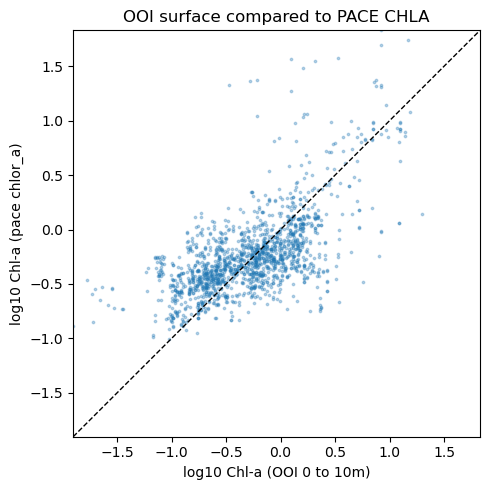

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_parquet("data/CHLA_ooi_profiles_plus_PACE.parquet")
df_clean = df.dropna(subset=["CHLA_0_10"])

# Take logs (natural log; use np.log10 if you prefer log10)
y_ooi = df_clean["CHLA_0_10"].values
y_pace = df_clean["pace_chlor_a"].values

# Mask: positive & finite in both
mask = (
    np.isfinite(y_ooi) &
    np.isfinite(y_pace) &
    (y_ooi > 0) &
    (y_pace > 0)
)

y_ooi = y_ooi[mask]
y_pace = y_pace[mask]

y_ooi = np.log10(y_ooi)
y_pace = np.log10(y_pace)

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_ooi, y_pace, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_ooi.min(), y_pace.min()),
    max(y_ooi.max(), y_pace.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("log10 Chl-a (OOI 0 to 10m)")
plt.ylabel("log10 Chl-a (pace chlor_a)")
plt.title("OOI surface compared to PACE CHLA")
plt.tight_layout()
plt.show()